In [1]:
import numpy as np
from Turtlebot_Kinematics import *
import matplotlib.pyplot as plt


In [2]:
MAX_V = 22.2
translate_differential_drive(MAX_V, -MAX_V)

(0.0, -2.775)

In [3]:
from run_util import load_ENV
from environment import Environment
from time import time

In [4]:
ENV = load_ENV("simple", False)
ENV.set_robo_state(np.array([1000, 400, np.pi / 4]))

loading simple


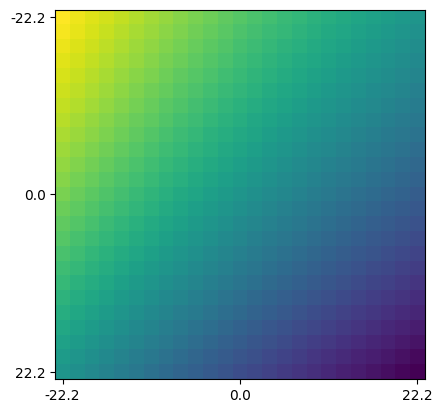

0.04699826240539551


In [5]:
dt = 1 / 20
v_space = np.linspace(-MAX_V, MAX_V, 25)
sensor_fusion = ENV.get_sensor_fusion()

# DWA like grid sampling
start_time = time()
fitness_grid = np.array([
    [ENV.fitness_single(pos=move_turtle(ENV.robo_state ,*translate_differential_drive(v_left, v_right), dt)[:2], sensor_fusion=sensor_fusion) for v_left in v_space]
    for v_right in v_space
])
process_time = time() - start_time

# rendering
fig, ax = plt.subplots()
im = ax.imshow(fitness_grid)
tick_locs = [0, int(len(v_space)/2), len(v_space)-1]
labels = [round(v, 1) for v in v_space[tick_locs]]
ax.set_xticks(tick_locs, labels=labels)
ax.set_yticks(tick_locs, labels=labels)
plt.show()
print(process_time)

In [6]:
from dwa_controller import DWA_Controller

DWA = DWA_Controller()

In [7]:
DWA(ENV)

(-16.357894736842105, -0.7302631578947367)

In [12]:
from types import NoneType


MIN_V = - MAX_V
dt = 0.05

def generate_v_vector(horizon=10):
    v_range = 2 * MAX_V
    vec = np.array([MIN_V]*horizon*2) + np.random.rand(horizon*2) * v_range
    return vec

def translate_vector(vec):
    out = []
    for i in range(0,len(vec), 2):
        sub_vec = vec[i:i+2]
        trans_v = translate_differential_drive(*sub_vec)
        out.append(trans_v)
    return out

def fitness(vec, env=ENV, discount=0.98):
    trans_v_list = translate_vector(vec)
    positions = []
    cur_state = env.get_internal_state()
    sensor_fusion = env.get_sensor_fusion()
    overall_fit = 0
    for i, (v, w) in enumerate(trans_v_list):
        cur_pos = move_turtle(cur_state, v, w, dt)
        positions.append(cur_pos)
        fit = env.fitness_single(cur_pos[0:2], sensor_fusion=sensor_fusion)
        print((v,w), "->", fit)
        if fit >= env.collision_penalty:
            overall_fit += env.collision_penalty * (len(trans_v_list) - i)
        else: overall_fit += fit*discount**i
    return overall_fit, positions

def gen_swarm(horizon=10, pop_size=10):
    return [generate_v_vector(horizon) for _ in range(pop_size)]

def disturb(vec):
    return vec * np.random.rand(len(vec))

def apply_swarm_forces(ind, ind_best, global_best, velocity, inertia=0.5, cog=0.5, soc=0.5):
    new_velocity = velocity * inertia + cog * disturb(ind_best - ind) + soc * disturb(global_best - ind) 
    new_ind = ind + new_velocity
    for i in range(len(new_ind)):
        val = new_ind[i]
        if val >= MAX_V:
            new_ind[i] = MAX_V
            new_velocity[i] = 0
        elif val <= MIN_V:
            new_ind[i] = MIN_V
            new_velocity[i] = 0
    return new_ind, new_velocity

def particle_swarm_optimization(env:Environment, pop, charged_pop=[], iterations=100):
    # ATTENTION!: fitness is minimized
    sensor_fusion = env.get_sensor_fusion()
    fit = lambda state: env.fitness_single(state[:2], sensor_fusion)
    # TODO: make compatible with charged particles
    velocities = [np.zeros_like(ind) for ind in pop]
    individual_best = list(pop)
    individual_fit = [fit(ind) for ind in individual_best]
    global_best = individual_best[np.argmin(individual_fit)]
    global_fit = np.min(individual_fit)
    for iteration in range(iterations):
        new_pop = []
        for i,ind in enumerate(pop):
            new_ind, velocities[i] = apply_swarm_forces(ind, individual_best[i], global_best, velocities[i])
            new_pop.append(new_ind)
            new_fit = fit(new_ind)
            if new_fit < individual_fit[i]:
                individual_fit[i] = new_fit
                individual_best[i] = new_ind
                if new_fit < global_fit:
                    global_fit = new_fit
                    global_best = new_ind
        if iteration % 20 == 19:
            print(f"#{iteration}:", global_fit, "\n", individual_best, "\n")
    print("VELOCITIES:", velocities)
    return global_best, global_fit


pop = gen_swarm()
particle_swarm_optimization(ENV, pop)


#19: 470.42176797232185 
 [array([ 22.2       ,  12.36013794,   2.19160924, -18.09955733,
         1.16051888,  14.52351105,   1.4435311 ,   7.85272951,
         4.49511484,  -7.65571094,  -2.16806393,  13.02573927,
        -3.2600325 ,   9.31976874,  -9.68770217,  -7.84590482,
        -8.71298839, -13.24490766, -17.65149871,   5.61684845]), array([ 22.04656205,  22.2       ,  -0.3982016 , -18.29439295,
         1.85308759,  15.24385418,  -6.11907102,  14.79423018,
         2.77617726,  -9.3353799 ,  -5.99103387,  11.3770536 ,
       -12.87604824,   6.6052194 , -14.04706467,  -1.8028831 ,
        -5.69789634,  -8.82459385, -18.74037632,   3.71030269]), array([ 22.2       ,  15.25380313,   2.91458132, -15.846225  ,
         5.78619187,  16.10451017,  -6.16345724,  16.35729359,
         2.93265136,  -9.07739952,  -7.8076903 ,  18.74645889,
       -12.73935432,   9.2592344 , -14.49958321,  -0.40175714,
        -2.62506229,   1.13864149, -18.85485524,   7.1111831 ]), array([ 22.2       ,  

(array([ 22.2       ,  22.2       ,   7.99351719, -15.09517712,
          0.27689844,  13.84186961,   1.41591762,   8.36435103,
          1.8938425 ,  -3.58841193,  -5.26225985,  13.615927  ,
        -13.63379846,   2.71450034, -13.30870705,  -2.27175788,
         -7.94137937, -10.59078268,   6.13803372,   0.33596785]),
 470.4090040710435)

In [23]:
from pso_controller import Multi_PSO_Controller
from timeit import timeit

mpso = Multi_PSO_Controller()
sensor_fusion = ENV.get_sensor_fusion()

own_best = mpso.generate_v_vector(10)
global_best = mpso.generate_v_vector(10)
print("fitness:", timeit(lambda: mpso.fitness(generate_v_vector(10), ENV, sensor_fusion=sensor_fusion), number=10000))
print("forces:", timeit(lambda: mpso.apply_swarm_forces(generate_v_vector(10), own_best, global_best, generate_v_vector(10)/10), number=10000))

fitness: 7.300010299979476
forces: 0.32304439999279566
